In [401]:
using Revise
using Pkg
Pkg.activate("../vis")
Pkg.develop(path="../tools/ABM")
using Glob
using NPZ
using Plots
using CSV
using DataFrames
using StatsBase
import Seaborn
using StatsPlots
using ABM
using LinearAlgebra
using Base.Iterators
using Serialization

  Activating project at `/data/gpfs/projects/punim0638/stephenz/revised-waddington-abm/vis`
   Resolving package versions...
  No Changes to `/data/gpfs/projects/punim0638/stephenz/revised-waddington-abm/vis/Project.toml`
  No Changes to `/data/gpfs/projects/punim0638/stephenz/revised-waddington-abm/vis/Manifest.toml`


In [406]:
FIG_DIR="../figures/"
PLT_CELLx, PLT_CELLy=350, 350
dirs = glob("../jobs/job_*/");
is_null = contains.(dirs, "nulltemp");

In [407]:
# load job files 
suffix=""
outputs_all = map(x -> try Dict(:fmedian => npzread(string(x, "/fmedian$(suffix).npy")),
                            :sim => deserialize(string(x, "sim$(suffix).out")), 
                            :sim_init => deserialize(string(x, "sim_init$(suffix).out")), 
                            :empirical => deserialize(string(x, "X_empirical$(suffix).out")), 
                            :trace => deserialize(string(x, "param_trace$(suffix).out")))
    catch e missing end, dirs);
completed_jobs = findall(x -> ~(x === missing), outputs_all);
outputs_all = outputs_all[completed_jobs]
dirs = dirs[completed_jobs];

In [408]:
# empirical data
X = outputs_all[1][:empirical]
X = Dict(k => v' for (k, v) in X);
# rank candidate solutions by mean loss over last 25 iterates 
flast = map(x -> mean(x[:fmedian][end-25:end]), outputs_all);

In [409]:
ylim = (0.05, 0.25)
plt1=plot(; xlabel = "iteration", ylabel = "loss", ylim = ylim)
[plot!(plt1, x[:fmedian]; legend = nothing, alpha = 0.1, c = :black) for x in outputs_all];
plt2=histogram(flast, bins = 25, size = (PLT_CELLx, PLT_CELLy/2), legend = nothing, orientation = :horizontal, ylim = ylim, xlabel = "Final value", color = :grey, yaxis = nothing, axis = false)
plt=plot(plt1, plt2; layout = grid(1, 2, widths = [0.7, 0.3]), size = (2*PLT_CELLx, PLT_CELLy), plot_title = "CMA-ES multistart optimization", link = :y)
savefig(string(FIG_DIR, "optim_trace.pdf"))
plt

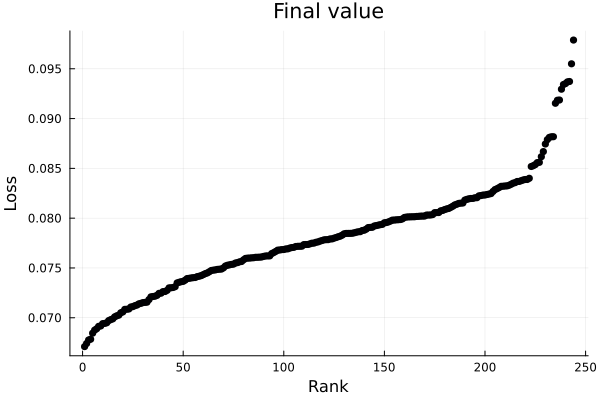

In [410]:
scatter(1:length(flast), sort(flast); title = "Final value", ylabel = "Loss", xlabel = "Rank", legend = false, marker_z = is_null[sortperm(flast)], markerstrokewidth = 0)

In [411]:
import Seaborn
nl=first(outputs_all)[:sim].states
D = 1.0
params = hcat(map(x -> vec(ABM.get_rate_matrix(x[:sim].Ψ, D, 1)), outputs_all)...)
params_init = hcat(map(x -> vec(ABM.get_rate_matrix(x[:sim_init].Ψ, D, 1)), outputs_all)...)
idx_best = sortperm(flast)[1:5];

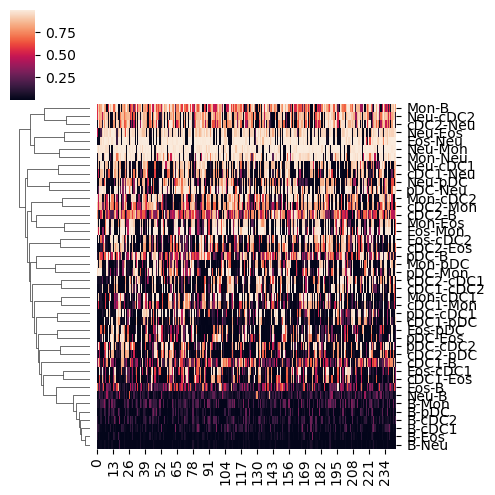

In [412]:
xlabels = map(((a, b), ) -> string(a, "-", b), vec(collect(product(nl, nl))));
is_diag = vec(I(length(nl)))
cg = Seaborn.clustermap(params[.~is_diag, :]; yticklabels = xlabels[.~is_diag], metric = "euclidean", col_cluster = false, figsize = (5, 5));

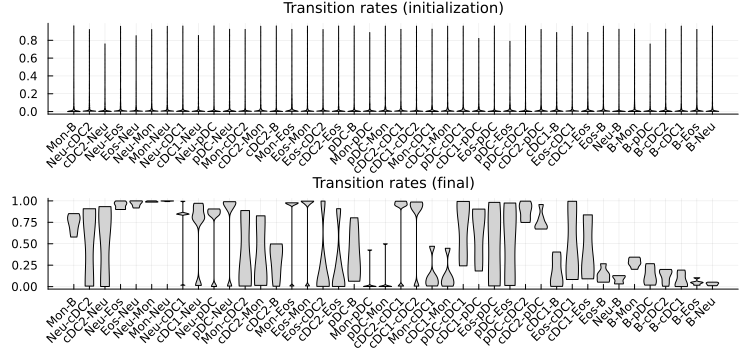

In [413]:
using StatsPlots
plt_init = StatsPlots.violin(params_init[.~is_diag, :][cg.dendrogram_row.reordered_ind .+ 1, :]'; 
    legend = nothing, 
    xticks = (1:length(xlabels[.~is_diag]), xlabels[.~is_diag][cg.dendrogram_row.reordered_ind .+ 1]),
    xrotation = 45, size = (750, 250), bottom_margin = 5Plots.mm, title = "Transition rates (initialization)", titlefontsize = 10, color = :lightgrey)
plt_fit = StatsPlots.violin(params[.~is_diag, idx_best][cg.dendrogram_row.reordered_ind .+ 1, :]'; 
    legend = nothing, 
    xticks = (1:length(xlabels[.~is_diag]), xlabels[.~is_diag][cg.dendrogram_row.reordered_ind .+ 1]),
    xrotation = 45, size = (750, 250), bottom_margin = 5Plots.mm, title = "Transition rates (final)", titlefontsize = 10, color = :lightgrey)
plot(plt_init, plt_fit, layout = (2, 1), size = (750, 350))

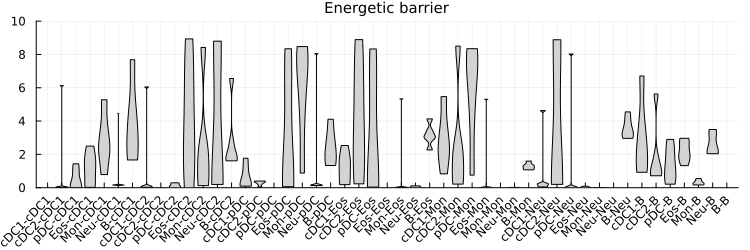

In [414]:
StatsPlots.violin(hcat(map(x -> vec(ABM.get_energetic_barrier(x[:sim].Ψ)), outputs_all[idx_best])...)'; 
    color = :lightgrey, legend = false, xticks = (1:length(xlabels), xlabels), xrotation = 45, size = (750, 250), bottom_margin = 7.5*Plots.mm, 
    ylim = (0, 10), 
    title = "Energetic barrier", titlefontsize = 10)

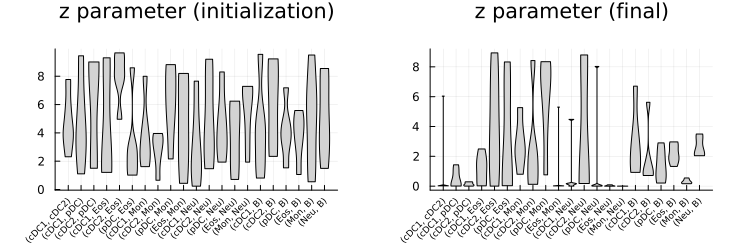

In [415]:
xlabels = map(((a, b), ) -> "($a, $b)", ABM.vech_strict(collect(product(nl, nl))))
plot(StatsPlots.violin(hcat(map(x -> x[:sim_init].Ψ.z, outputs_all[idx_best])...)'; 
    color = :lightgrey, legend = false, xticks = (1:length(xlabels), xlabels), xtickfontsize = 6, xrotation = 45, size = (750, 250), margin = 7.5*Plots.mm,
    title = "z parameter (initialization)"), 
StatsPlots.violin(hcat(map(x -> x[:sim].Ψ.z, outputs_all[idx_best])...)'; 
    color = :lightgrey, legend = false, xticks = (1:length(xlabels), xlabels), xtickfontsize = 6, xrotation = 45, size = (750, 250), margin = 7.5*Plots.mm,
    title = "z parameter (final)"))

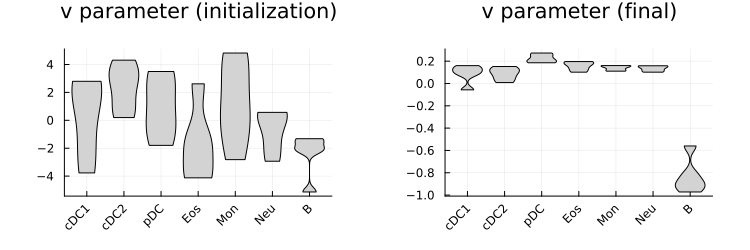

In [416]:
plot(StatsPlots.violin(hcat(map(x -> x[:sim_init].Ψ.v, outputs_all[idx_best])...)'; 
    color = :lightgrey, legend = false, xticks = (1:length(nl),nl), xrotation = 45, size = (750, 250), margin = 7.5*Plots.mm,
    title = "v parameter (initialization)"), 
StatsPlots.violin(hcat(map(x -> x[:sim].Ψ.v, outputs_all[idx_best])...)'; 
    color = :lightgrey, legend = false, xticks = (1:length(nl),nl), xrotation = 45, size = (750, 250), margin = 7.5*Plots.mm,
    title = "v parameter (final)"))

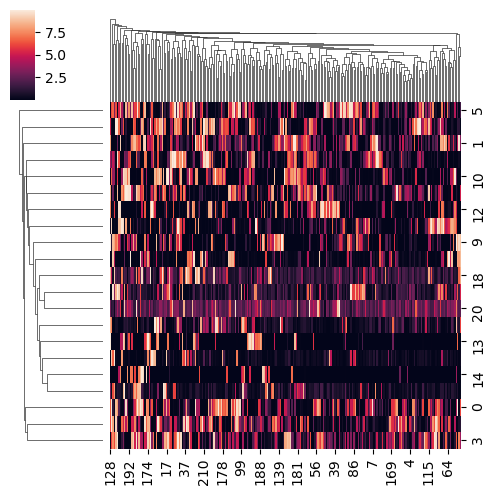

PyObject <seaborn.matrix.ClusterGrid object at 0x148fd455bc70>

In [417]:
Seaborn.clustermap(hcat(map(x -> x[:sim].Ψ.z, outputs_all)...); figsize = (5, 5))

In [418]:
job_idx=sortperm(flast)[1]
dirs[job_idx]

"../jobs/job_227/"

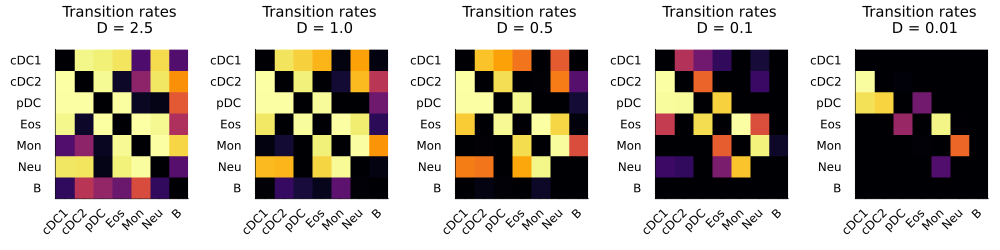

In [420]:
using NNlib
plts_all = []
for D in [2.5, 1.0, 0.5, 0.1, 0.01]
    Λ_all = map(x -> ABM.get_rate_matrix(x[:sim].Ψ, D, 1), outputs_all); 
    nl=first(outputs_all)[:sim].states;
    Λ = Λ_all[job_idx]
    plt=heatmap(relu.(Λ), 
                yflip = true, 
                xticks = (collect(1:length(nl)), nl), yticks = (collect(1:length(nl)), nl),
                title = "Transition rates \n D = $D", 
                clim = (0, 1), 
                size = (PLT_CELLx, PLT_CELLy), titlefontsize = 10, xrotation = 45)
    push!(plts_all, plt)
end
plot(plts_all...; layout = (1, 5), size = (1000, 250), colorbar = nothing, bottom_margin = 7.5Plots.mm, top_margin = 7.5Plots.mm)

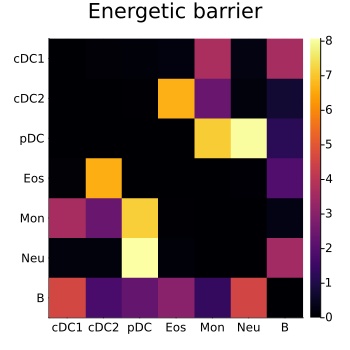

In [421]:
Plots.heatmap(ABM.get_energetic_barrier(outputs_all[job_idx][:sim].Ψ), 
        yflip = true,
        xticks = (1:length(nl), nl), yticks = (1:length(nl), nl), 
        title = "Energetic barrier", size = (PLT_CELLx, PLT_CELLy))

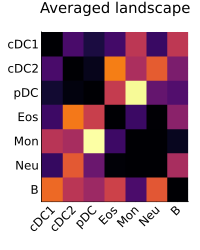

In [427]:
Plots.heatmap(mean([ABM.get_energetic_barrier(outputs_all[i][:sim].Ψ) for i = sortperm(flast)[1:5]]); 
    yflip = true, xticks = (1:length(nl), nl), yticks = (1:length(nl), nl), size = (200, 250), colorbar = nothing, xrotation = 45, 
    title = "Averaged landscape", titlefontsize = 10)

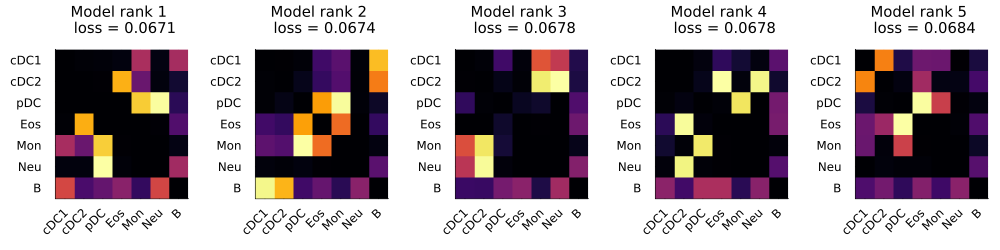

In [428]:
using Printf
plot([Plots.heatmap(ABM.get_energetic_barrier(outputs_all[i][:sim].Ψ), 
        yflip = true,
        xticks = (1:length(nl), nl), yticks = (1:length(nl), nl), 
        title = @sprintf("Model rank %d \n loss = %.4f", j, flast[i]), titlefontsize = 10, 
        size = (PLT_CELLx, PLT_CELLy)) for (j, i) = enumerate(sortperm(flast)[1:5])]...;
layout = (1, 5), size = (1000, 250), colorbar = nothing, bottom_margin = 7.5Plots.mm, top_margin = 7.5Plots.mm, xrotation = 45)

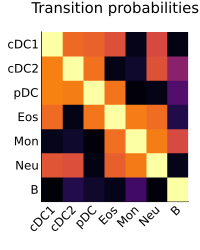

In [437]:
using LaTeXStrings
P_τ_all = [ABM.get_transition_matrix(x[:sim].Ψ, 1, x[:sim].T, D) for x in outputs_all]
plt=heatmap(P_τ_all[idx_best[1]], 
    yflip = true, xticks = (collect(1:length(nl)), nl), 
    yticks = (collect(1:length(nl)), nl), 
    title = "Transition probabilities", titlefontsize = 10, xrotation = 45, 
    size = (200, 250), clim = (0, 0.05), colorbar = nothing)
plt

In [438]:
sim = outputs_all[job_idx][:sim];
s = sim.stages[1]
N_clones_sample = 250
ν = ABM.sample(sim; N = N_clones_sample)
μ = Dict(k => Matrix(v) for (k, v) in X);

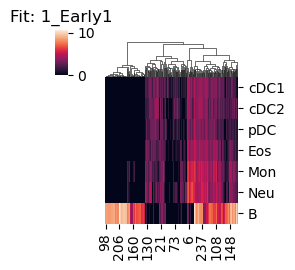

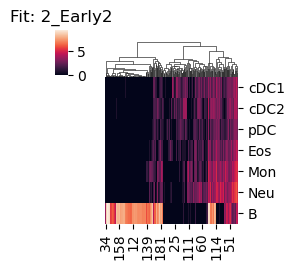

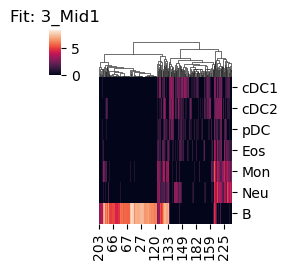

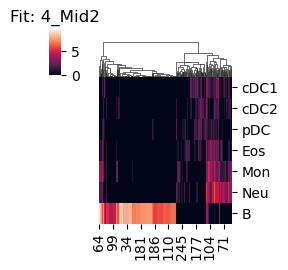

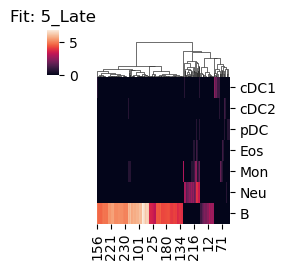

In [439]:
col_norm = x -> x ./ sum(x; dims = 1)
for s in sim.stages
    Seaborn.clustermap(log1p.(ν[s]), yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), rasterized = true)
    Seaborn.gca().set_title("Fit: $s")
    Seaborn.savefig(string(FIG_DIR, "clustermap_$(s)_fit.pdf"))
end

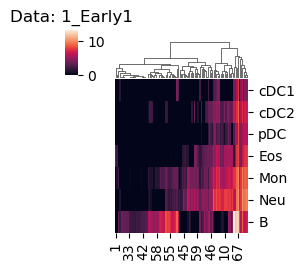

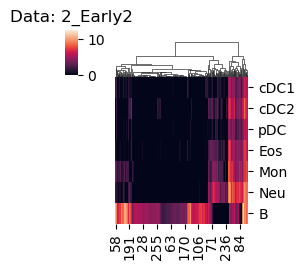

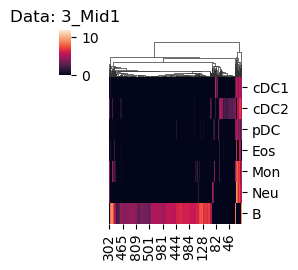

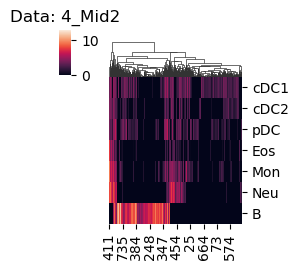

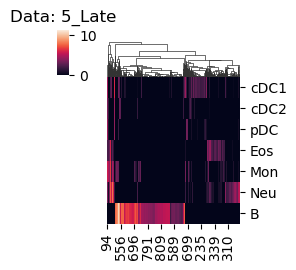

In [440]:
for s in sim.stages
    Seaborn.clustermap(log1p.(μ[s]), yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), rasterized = true)
    Seaborn.gca().set_title("Data: $s")
    Seaborn.savefig(string(FIG_DIR, "clustermap_$(s)_empirical.pdf"))
end

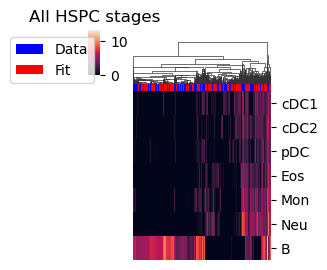

In [441]:
N = 1_000
μ = Dict(s => hcat([collect(x) for x in eachcol(X[s])]...) for s in sim.stages);
μ_subsampled = Dict(k => x[:, rand(1:end, N)] for (k, x) in μ);
ν = ABM.sample(sim; N = N);
μ_all = log1p.(hcat([x for (k, x) in μ_subsampled]...)) # data
ν_all = log1p.(hcat([x for (k, x) in ν]...))  # fit
clustmap = Seaborn.clustermap(hcat(μ_all, ν_all);
            col_colors = vcat(fill("blue", size(μ_all, 2)), fill("red", size(ν_all, 2))), 
            yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), metric = "euclidean", xticklabels = "", rasterized = true)
Seaborn.gca().set_title("All HSPC stages")
Patch=Seaborn.matplotlib.patches.Patch
Seaborn.matplotlib.pyplot.legend([Patch(facecolor="blue"), Patch(facecolor="red")], ["Data", "Fit"], title="")
Seaborn.savefig(string(FIG_DIR, "clustermap_all.pdf"))

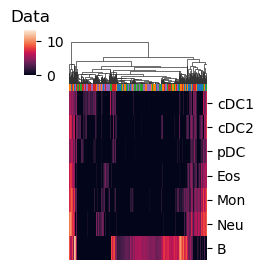

In [442]:
using Colors
colordict = Dict(k => string("#", hex(palette(:tab10)[i])) for (i, k) in enumerate(sim.stages))
μ_all_stages = vcat([repeat([k, ], size(x, 2)) for (k, x) in μ_subsampled]...);
Seaborn.clustermap(μ_all;
        col_colors = [colordict[s] for s in μ_all_stages], 
        yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), metric = "euclidean", xticklabels = "", rasterized = true)
Seaborn.gca().set_title("Data")
Seaborn.savefig(string(FIG_DIR, "clustermap_data_all.pdf"))

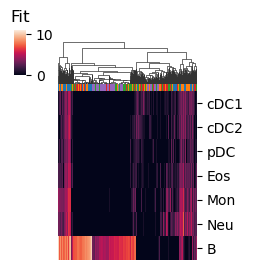

In [443]:
colordict = Dict(k => string("#", hex(palette(:tab10)[i])) for (i, k) in enumerate(sim.stages))
ν_all_stages = vcat([repeat([k, ], size(x, 2)) for (k, x) in ν]...);
Seaborn.clustermap(ν_all;
        col_colors = [colordict[s] for s in ν_all_stages], 
        yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), metric = "euclidean", xticklabels = "", rasterized = true)
Seaborn.gca().set_title("Fit")
Seaborn.savefig(string(FIG_DIR, "clustermap_fit_all.pdf"))

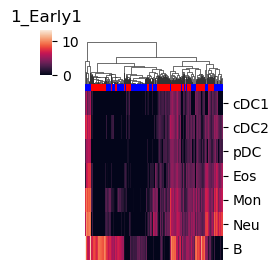

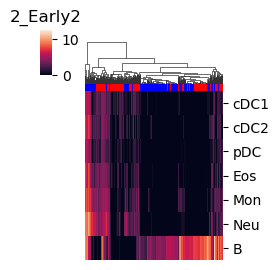

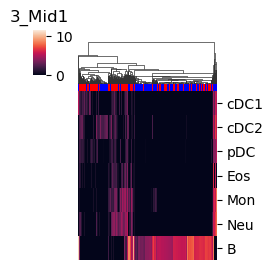

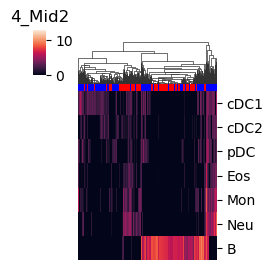

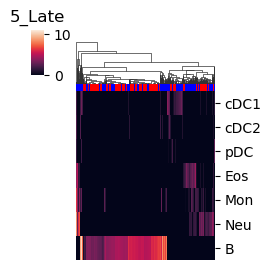

In [444]:
for s in sim.stages
    colors = vcat(fill("blue", size(μ_subsampled[s], 2)), fill("red", size(ν[s], 2)))
    clustmap = Seaborn.clustermap(log1p.(hcat(μ_subsampled[s], ν[s]));
                col_colors = colors, xticklabels = [], yticklabels = sim.states, row_cluster = false, figsize = (2.5, 2.5), metric = "euclidean", rasterized = true)
    # Seaborn.matplotlib.pyplot.legend([Patch(facecolor="blue"), Patch(facecolor="red")], ["Data", "Fit"], title="")
    Seaborn.gca().set_title("$s")
    Seaborn.savefig(string(FIG_DIR, "clustermap_$(s)_joined.pdf"))
end

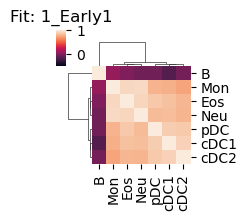

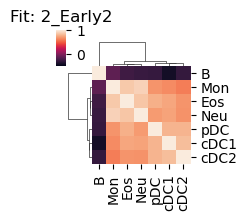

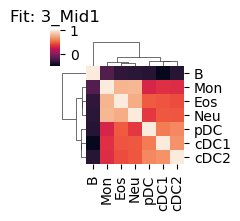

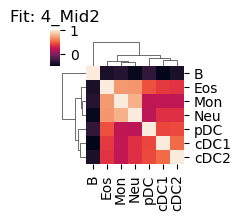

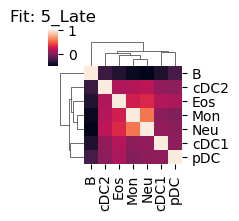

In [445]:
for s in sim.stages
    Seaborn.clustermap(cor(log1p.(ν[s])'), xticklabels = sim.states, yticklabels = sim.states, figsize = (2, 2), vmin = -0.5, vmax = 1)
    Seaborn.gca().set_title("Fit: $s")
    Seaborn.savefig(string(FIG_DIR, "corrs_fit_$s.pdf"))
end

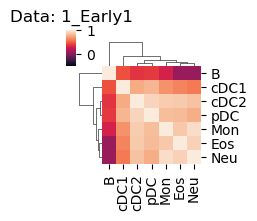

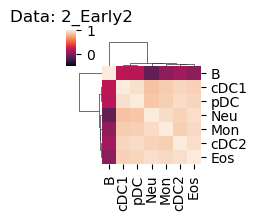

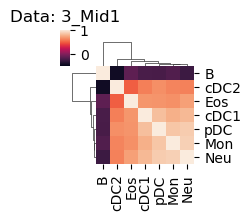

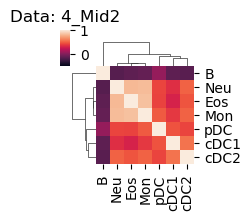

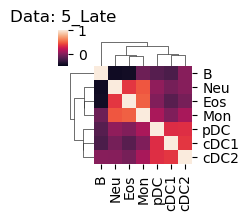

In [446]:
for (i, s) in enumerate(sim.stages)
    function nan_zero(x)
        y = copy(x)
        y[isnan.(y)] .= 0
        y
    end
    Seaborn.clustermap(nan_zero(cor(log1p.(μ[s])')), xticklabels = sim.states, yticklabels = sim.states, figsize = (2, 2), vmin = -0.5, vmax = 1)
    Seaborn.gca().set_title("Data: $s")
    Seaborn.savefig(string(FIG_DIR, "corrs_empirical_$s.pdf"))
end

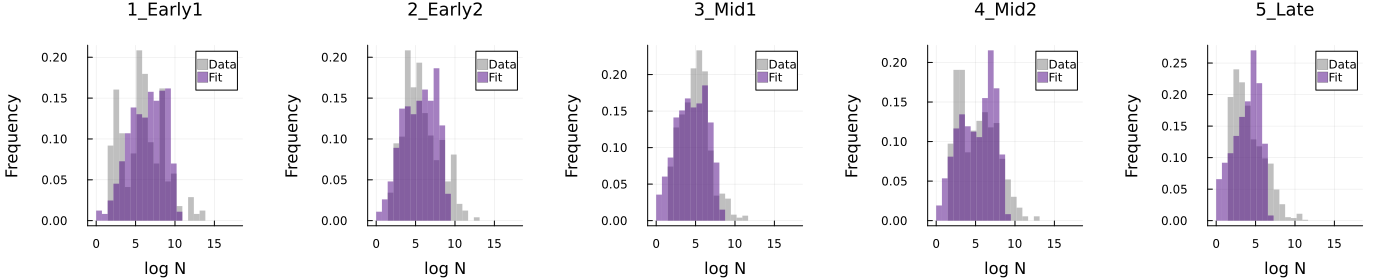

In [447]:
plts_all = []
bins = range(0, 17.5; length = 25)
for (i, s) in enumerate(sim.stages)
    plt=Plots.histogram(log1p.(vec(sum(μ_subsampled[s]; dims = 1))); 
                label = "Data", alpha = 0.5, bins = bins, title = "$s", normalize = :pdf, 
                xlabel = "log N", ylabel = "Frequency", linewidth = 0, color = :grey, titlefontsize = 12)
    Plots.histogram!(log1p.(vec(sum(ν[s]; dims = 1))); 
                label = "Fit", alpha = 0.5, bins = bins, normalize = :pdf, linewidth = 0, color = :indigo)
    push!(plts_all, plt)
end
plt=Plots.plot(plts_all...; layout = (1, 5), size = (4*PLT_CELLx, 4/5*PLT_CELLy), margin = 7.5*Plots.mm)
Plots.savefig(joinpath(FIG_DIR, "clone_sizes_histograms.svg"))
plt

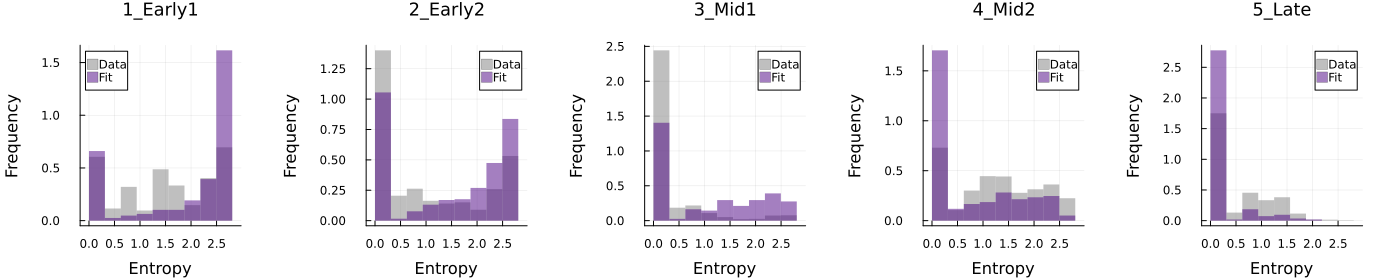

In [448]:
using LogExpFunctions
plts_all = []
bins = range(0, log2(length(sim.states)); length = 10)
for (i, s) in enumerate(sim.stages)
    plt=Plots.histogram(-mapreduce(x -> xlogx(x)/log(2), +, col_norm(log1p.(μ_subsampled[s])); dims = 1)'; 
                    label = "Data", alpha = 0.5, bins = bins, title = "$s", normalize = :pdf, 
                    xlabel = "Entropy", ylabel = "Frequency", linewidth = 0, color = :grey, titlefontsize = 12)
    histogram!(-mapreduce(x -> xlogx(x)/log(2), +, col_norm(log1p.(ν[s])); dims = 1)'; 
                    label = "Fit", alpha = 0.5, bins = bins, normalize = :pdf, linewidth = 0, color = :indigo)
    push!(plts_all, plt)
end
plt=Plots.plot(plts_all...; layout = (1, 5), size = (4*PLT_CELLx, 4/5*PLT_CELLy), margin = 7.5*Plots.mm)
Plots.savefig(joinpath(FIG_DIR, "clone_entropies_histogram.svg"))
plt

In [449]:
# using ProgressMeter
# using Distributions
# 
# stages = sim.stages
# N = 25
# N_samples = 1_000
# L_sim = @showprogress [ABM.L(ABM.optvec(sim), X, sim; kw_sample = Dict(:N => N_samples))[1] for _ = 1:N];
# # L_null_landscape = @showprogress [ABM.L(ABM.optvec(sim)*0, X, sim)[1] for _ = 1:N];
# sim_null_noise = outputs_all[job_null_idx][:sim];
# L_null_noise = @showprogress [ABM.L(ABM.optvec(sim_null_noise), X, sim_null_noise; kw_sample = Dict(:N => N_samples))[1] for _ = 1:N];
# 
# using StatsPlots
# StatsPlots.boxplot([L_sim, L_null_noise], xticks = (1:2, ["Variable", "Fixed"]), xtickfontsize = 12, legend = nothing, color = :lightgrey, size = (250, 400), ylabel = "OT distance", title = "Landscape height")

In [455]:
using Random
using AbstractTrees

In [456]:
vs = collect(1:sim.N_states)
function draw_segment(n, line_segment_list = [])
    x0 = normalize(n.state, 1)
    for x in n.children
        x1 = normalize(x.state, 1)
        ls = [(x0, x1), (n.generation, x.generation), sum(n.state)]
        push!(line_segment_list, ls)
        plot!([sum(ls[1][1] .* vs), sum(ls[1][2] .* vs)], [ls[2][1], ls[2][2]], linewidth = ls[3], alpha = 0.5)
        draw_segment(x, line_segment_list)
    end
    return line_segment_list
end

draw_segment (generic function with 2 methods)

In [457]:
# plt=plot(; legend = nothing, yflip = true)
# lsl = draw_segment(tree.root)
# plt
# 
# df_tree = DataFrame(hcat([vcat(x0, x1) for ((x0, x1), (t0, t1), w) in lsl]...)', Symbol.(vcat(string.(sim.states, "_start"), string.(sim.states, "_end"))));
# df_tree[!, :w] = last.(lsl)
# df_tree[!, :t0] = map(x -> x[end-1][1], lsl)
# df_tree[!, :t1] = map(x -> x[end-1][2], lsl)
# CSV.write("../data/tree.csv", df_tree)

In [458]:
sum(tree.root.state)

102.0

In [459]:
Random.seed!(0)
for s in sim.stages
    count = 0
    while count < 10
        @info count
        tree = ABM.sample_traj_tree(sim, s; t_init = sim.t_stages[s]);
        ABM.accum_state_num(tree.root);
        if sum(tree.root.state) > 2500 # discard trees with too many leaves
            continue
        end
        lsl = draw_segment(tree.root)
        df_tree = DataFrame(hcat([vcat(x0, x1) for ((x0, x1), (t0, t1), w) in lsl]...)', Symbol.(vcat(string.(sim.states, "_start"), string.(sim.states, "_end"))));
        df_tree[!, :w] = last.(lsl)
        df_tree[!, :t0] = map(x -> x[end-1][1], lsl)
        df_tree[!, :t1] = map(x -> x[end-1][2], lsl)
        CSV.write("../data/tree_stage_$(s)_$(count).csv", df_tree)
        count += 1
    end
end

[ Info: 0
[ Info: (Dict{Int64, ABM.LineageTreeNode}(1 => ABM.LineageTreeNode(1, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0, ABM.LineageTreeNode[])), ABM.LineageTreeNode(1, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0, ABM.LineageTreeNode[]))
[ Info: 1
[ Info: (Dict{Int64, ABM.LineageTreeNode}(1 => ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 0, ABM.LineageTreeNode[])), ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 0, ABM.LineageTreeNode[]))
[ Info: 2
[ Info: (Dict{Int64, ABM.LineageTreeNode}(1 => ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 0, ABM.LineageTreeNode[])), ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 0, ABM.LineageTreeNode[]))
[ Info: 3
[ Info: (Dict{Int64, ABM.LineageTreeNode}(1 => ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 0, ABM.LineageTreeNode[])), ABM.LineageTreeNode(1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 0, ABM.LineageTreeNode[]))
[ Info: 4
[ Info: (Dict{Int64, ABM.LineageTreeNode}(1 => ABM.LineageTree

In [460]:
# readouts 
N = 2500
ν = ABM.sample(sim; N = N)
for s in sim.stages
    CSV.write("../data/clone_readout_$s.csv", DataFrame(ν[s]', sim.states))
end
CSV.write("../data/clone_readout_all.csv", DataFrame(hcat(values(ν)...)', sim.states))

"../data/clone_readout_all.csv"

In [ ]:
# save 5 best models
function save_sample(i, j)
    sim = outputs_all[i][:sim]
    N = 2500
    ν = ABM.sample(sim; N = N)
    CSV.write("../data/clone_readout_all_$j.csv", DataFrame(hcat(values(ν)...)', sim.states))
end

for (j, i) = enumerate(sortperm(flast)[1:5])
    save_sample(i, j)
end